# *k*-NN 

<font color=blue>**Note**  
For a random value, we see the k nearest neighbor and we decide the label of thie random value: 
    <img src="./TD6_1.jpg">
If 1nn is applied, the oberservation is classified as OK.  
If 2nn is applied, we can take no decision as there is a red point and a blue point near it.  
If 3nn is applied, the observation is classified as faluty.  
So what is the optimal value of $k$?

The idea is to apply a **cross validation**:   
- Use a data set to train each $k$ and a test set each $k$ so that we can find the k who give the best result.    

Risk:
- The size of data set, $k$ may depend on the size of data set.
- The data set may not be really presentive such that there may be some rigion that it's difficult to define.
- The proportion of functionning and false data in the data set.
</font>

In [1]:
## IMPORT
import numpy as np
import matplotlib.pyplot as plt
import pdb

### choice of a toy set

In [2]:
def ToySet(n0, n1, useCase):
    if useCase==1:
        mX0, mX1 = NestedSpirals(n0, n1)
    elif useCase==2:
        mX0, mX1 = ConcentricCircles(n0, n1)
    elif useCase==3:
        mX0, mX1 = NestedHalfCircle(n0, n1)
    else: 
        raise ValueError("invalid useCase")
    vY0 = np.zeros(n0)
    vY1 = np.ones(n1)
    mX = np.concatenate((mX0, mX1), axis=0)
    vY = np.concatenate((vY0, vY1), axis=0)
    return mX, vY

### Generation of data set (3 possibles data set)

In [3]:
def NestedSpirals(n0, n1):
    # Inferior radius
    rho0i = 1
    rho1i = -1
    # Superior radius
    rho0s = 5
    rho1s = -5
    # Radius array
    vRho0 = np.linspace(rho0i, rho0s, n0)
    vRho1 = np.linspace(rho1i, rho1s, n1)
    # Inferior angle
    theta0i = 0
    theta1i = 0
    # Superior angle (NumberOfLoops*2*pi)
    theta0s = 3*2*np.pi
    theta1s = 3*2*np.pi
    # Angle array
    vTheta0 = np.linspace(theta0i, theta0s, n0)
    vTheta1 = np.linspace(theta1i, theta1s, n1)
    # Polar to cartesian
    mX0 = np.concatenate((np.vstack(vRho0*np.cos(vTheta0)), np.vstack(vRho0*np.sin(vTheta0))), axis=1)
    mX1 = np.concatenate((np.vstack(vRho1*np.cos(vTheta1)), np.vstack(vRho1*np.sin(vTheta1))), axis=1)
    # Noise
    noise = 0.1
    mX0 = mX0+np.random.randn(n0, 2)*noise
    mX1 = mX1+np.random.randn(n1, 2)*noise
    return mX0, mX1

In [4]:
def ConcentricCircles(n0, n1):
    # Radius min and max
    vRho0 = np.array([0.75, 1.25])
    vRho1 = np.array([1, 1.5])
    # Determine the number of "circles"
    nb0 = len(vRho0)
    nb1 = len(vRho1)
    if not ((n0/nb0).is_integer() & (n1/nb1).is_integer()):
        raise ValueError("inconsitsency between observations numbers and ConcentricCircles configuration")
    # Inferior and superior angle
    thetai = 0
    thetas = 2*np.pi
    # First class
    mX0 = np.empty((0, 2))
    for ic in range(nb0):
        vTheta = np.linspace(thetai, thetas, int(n0/nb0))
        mX0 = np.concatenate((mX0, np.concatenate((np.vstack(vRho0[ic]*np.cos(vTheta)),
                                                   np.vstack(vRho0[ic]*np.sin(vTheta))), axis=1)), axis=0)
    # 2nd class
    mX1 = np.empty((0, 2))
    for ic in range(nb1):
        vTheta = np.linspace(thetai, thetas, int(n1/nb1))
        mX1 = np.concatenate((mX1, np.concatenate((np.vstack(vRho1[ic]*np.cos(vTheta)),
                                                   np.vstack(vRho1[ic]*np.sin(vTheta))), axis=1)), axis=0)
    # Noise
    noise = 0.05
    mX0 = mX0+np.random.randn(n0, 2)*noise
    mX1 = mX1+np.random.randn(n1, 2)*noise
    return mX0, mX1

In [5]:
def NestedHalfCircle(n0, n1):
    # Center
    vC0 = np.array([-0.5, -0.25])
    vC1 = np.array([0.5, 0.25])
    # Radius
    rho0 = 1
    rho1 = 1
    # Inferior and superior angles 
    theta0i = 0
    theta0s = np.pi
    theta1i = -np.pi
    theta1s = 0
    # Angle array
    vTeta0 = np.linspace(theta0i, theta0s, n0)
    vTeta1 = np.linspace(theta1i, theta1s, n1)
    # Polar to cartesian
    mX0 = np.concatenate((np.vstack(rho0*np.cos(vTeta0))+vC0[0], np.vstack(rho0*np.sin(vTeta0))+vC0[1]), axis=1)
    mX1 = np.concatenate((np.vstack(rho1*np.cos(vTeta1))+vC1[0], np.vstack(rho1*np.sin(vTeta1))+vC1[1]), axis=1)
    # noise
    noise = 0.1;
    mX0 = mX0+np.random.randn(n0, 2)*noise
    #mX0 = mX0+np.random.randn(n0, 2)*(np.vstack(np.abs(mX0[:, 1]))@np.array([[1, 1]]))
    mX1 = mX1+np.random.randn(n1, 2)*noise
    #mX1 = mX1+np.random.randn(n1, 2)*(np.vstack(np.abs(mX1[:, 1]))@np.array([[1, 1]]))
    return mX0, mX1

### Knn Algorithme

<font color=blue>
    
```mXApp``` and ```mYApp```is the learning data set, with the first beging the coorinate and the latter being the label.   
```mXTest``` is all the points that I want to classify(To be tested)  
```nXTest``` the number of points  I want to classify.
```vDist = np.sum(np.power(self.mXApp-(vOnes@np.asmatrix(mXTest[ix])), 2), axis=1)``` Get distances from one point ix of test set (mXTest) to **all points** of learning set (mXApp)

- case ```k==1```: we only need to see the minimum，we allocate the label of the closest to the tested point.
- case ```k!=1```: we need to see the closest k point
    - If we have one bigger than another, we choose the most label.
    - If we have case 50% and 50%, we go beyond the dominant and we sum the distance and we take the label that the cumulative distance is the closest.
 </font>

In [6]:
class MyKnnMdl():
    # Constructor
    def __init__(self, mXApp, vYApp, k=1):
        self.k = k
        self.vClass = np.unique(vYApp) # Number of classes (for today always 2 classes with labels 0 and 1)
        self.mXApp = mXApp
        self.vYApp = vYApp
    # Evluation Method 
    # m=matrix, v=vector, n=scalar
    def Eval(self, mXTest):
        nXTest = mXTest.shape[0]
        vYTest = np.empty((nXTest, ))
        vOnes = np.ones((self.vYApp.shape[0], 1))
        # Process Test dataset
        for ix in range(nXTest):
            # Get distances from one point ix of test set (mXTest) to all points of learning set (mXApp)
            vDist = np.sum(np.power(self.mXApp-(vOnes@np.asmatrix(mXTest[ix])), 2), axis=1)
            if self.k==1:
                # Get class of the closest observation 
                vYTest[ix] = self.vYApp[np.argmin(vDist)]
            else:
                # Get classes of the k closest observations
                vINn = np.squeeze(np.asarray(np.argsort(vDist, axis=0)[:self.k]))
                vDNn = np.squeeze(np.asarray(vDist[vINn]))
                vYNn = self.vYApp[vINn]
                # Count classes occurrences
                vCNn = np.zeros(len(self.vClass))
                for ic in range(len(self.vClass)):
                    vCNn[ic] = np.sum(vYNn==self.vClass[ic])
                # Get dominant class
                argMax = np.argmax(vCNn)
                if sum(vCNn==vCNn[argMax])==1:
                    # Get class of the dominant observations 
                    vYTest[ix] = self.vClass[argMax]
                else:
                    # Sum distances depending on dominant classes  
                    vArgDom = np.where(vCNn==vCNn[argMax])[0]
                    vDistDom = np.zeros(vArgDom.shape[0])
                    for ixd in range(len(vArgDom)):
                        vDistDom[ixd] = sum(vDNn[vYNn==self.vClass[vArgDom[ixd]]])
                    argMin = np.argmin(vDistDom)
                    # Get class with the lower average distance
                    vYTest[ix] = self.vClass[vArgDom[argMin]]
        return vYTest

### visualisation

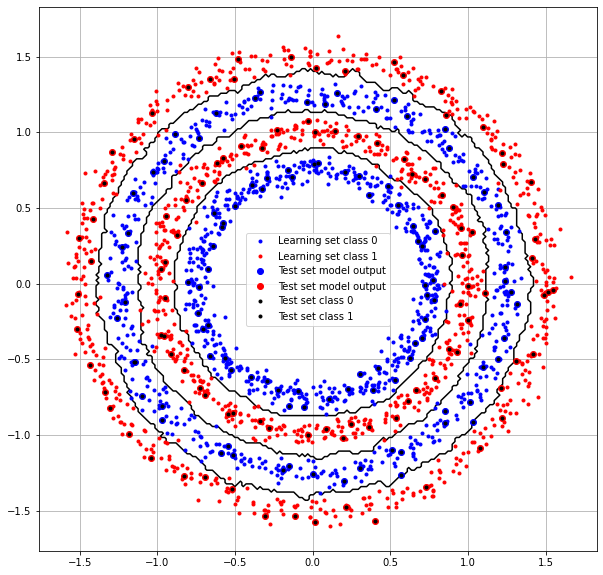

In [7]:
# Data generation
toySet = 2
[mXA,vYA] = ToySet(1000, 1000, toySet)
[mXT,vYT] = ToySet(100, 100, toySet)

# Evaluate NN-Mdl on test data set
mdlKppv = MyKnnMdl(mXApp=mXA, vYApp=vYA, k=50)
vYTe = mdlKppv.Eval(mXTest=mXT)

# Illustration in 2D
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(mXA[vYA==0, 0], mXA[vYA==0, 1], '.b', label='Learning set class 0')
ax.plot(mXA[vYA==1, 0], mXA[vYA==1, 1], '.r', label='Learning set class 1')
ax.plot(mXT[vYTe==0, 0], mXT[vYTe==0, 1], 'ob', label='Test set model output')
ax.plot(mXT[vYTe==1, 0], mXT[vYTe==1, 1], 'or', label='Test set model output')
ax.plot(mXT[vYT==0, 0], mXT[vYT==0, 1], '.k', label='Test set class 0')
ax.plot(mXT[vYT==1, 0], mXT[vYT==1, 1], '.k', label='Test set class 1')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
ax.set_ylim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
ax.grid(True)
ax.legend()

# Define grid
n1 = 200;
n2 = 200;
vX1 = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), n1)
vX2 = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), n2)
mX1, mX2 = np.meshgrid(vX1, vX2)
vX1g = mX1.reshape(np.prod(mX1.shape), 1)
vX2g = mX2.reshape(np.prod(mX2.shape), 1)
mXG = np.concatenate((mX1.reshape(np.prod(mX1.shape), 1), 
                      mX2.reshape(np.prod(mX2.shape), 1)), axis=1)
# Eval grid
vYG = mdlKppv.Eval(mXG)
# Add grid on illustration
ax.contour(mX1, mX2, vYG.reshape(n2, n1), levels=[0.5], colors='k')

### *kFold* Cross Validation

<font color=blue> We take k% of the data set to test.In practice, we build our two data sets with this. </font>

In [8]:
def CrossVal(mX, vY, kNN, kFold):
    nObs = len(vY)
    vP = np.random.permutation(nObs)
    mX = mX[vP, :]
    vY = vY[vP]
    vPerfVali = np.zeros((kFold, ))
    # For each fold
    for idk in range(0, kFold):
        # Split data for learning and validation
        vIndLear = np.concatenate((np.arange(0, int(nObs*(idk)/kFold)), np.arange(int(nObs*(idk+1)/kFold), nObs)))
        vIndVali = np.arange(int(nObs*(idk)/kFold)+1, int(nObs*(idk+1)/kFold))
        mXLear = mX[vIndLear, :]
        vYLear = vY[vIndLear]
        mXVali = mX[vIndVali, :]
        vYVali = vY[vIndVali]
        # "Modeling"
        mdlKppv = MyKnnMdl(mXApp=mXLear, vYApp=vYLear, k=kNN)
        # Perf assessment on validation set
        vYValiEst = mdlKppv.Eval(mXVali)
        vPerfVali[idk] = np.sum(vYValiEst==vYVali)/vYVali.shape[0]
    return vPerfVali

Text(0, 0.5, 'Ratio of correct decision')

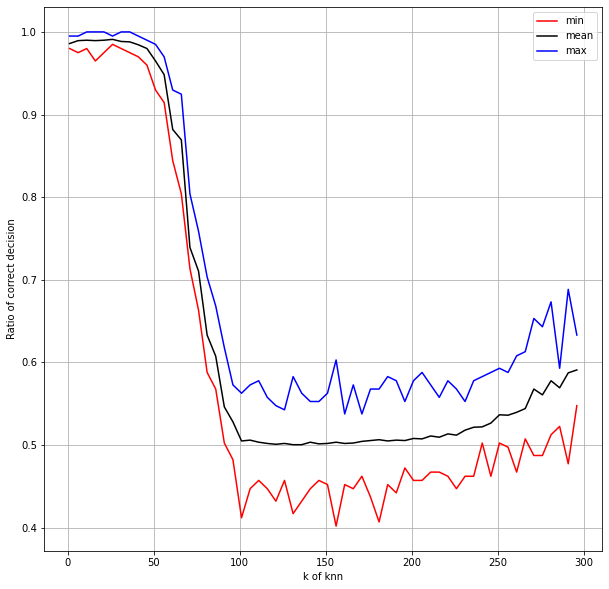

In [9]:
toySet = 2
[mXA, vYA] = ToySet(1000, 1000, toySet)
vK = np.arange(1, 300, 5)
kFold = 10
mPerf = np.zeros((vK.shape[0], kFold))
for idn in range(0, len(vK)):
    mPerf[idn, :] = CrossVal(mXA, vYA, vK[idn], kFold)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(vK, np.min(mPerf, axis=1), 'r', label='min')
ax.plot(vK, np.mean(mPerf, axis=1), 'k', label='mean')
ax.plot(vK, np.max(mPerf, axis=1), 'b', label='max')
ax.grid(True)
ax.legend()
ax.set_xlabel('k of knn')
ax.set_ylabel('Ratio of correct decision')